In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

Using backend: pytorch


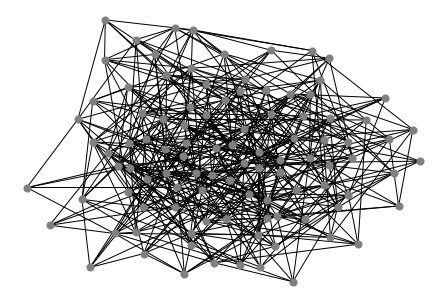

In [13]:
N = 100  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations
g = nx.nx.erdos_renyi_graph(N, 0.1)
nx.draw(g, node_size=50, node_color=[[.5, .5, .5,]])
g = dgl.DGLGraph(g)
plt.show()

In [14]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

In [15]:
print(g.ndata['deg'])

tensor([ 8.,  5., 10.,  9.,  8., 12.,  9., 10.,  8.,  9.,  9.,  8.,  6., 20.,
         8.,  6., 11., 10.,  9., 14.,  9., 11., 16.,  8.,  5.,  7., 11.,  8.,
        11., 16.,  6., 11.,  6.,  8., 11., 10., 16.,  9.,  7.,  8., 12.,  8.,
         9., 13.,  9., 10.,  9., 10.,  7., 11.,  7.,  6.,  9., 11.,  9., 10.,
        11., 11., 10.,  8.,  8., 12.,  5.,  7.,  7., 11.,  9., 17.,  9.,  6.,
         7., 10., 11., 10., 11., 11., 11.,  6., 10., 15.,  8., 12.,  7., 13.,
         9., 10.,  7.,  9.,  9.,  7.,  8., 11.,  6., 11., 11., 10.,  7.,  9.,
        11., 11.])


In [16]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In [17]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

In [18]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

In [10]:
def pagerank_naive(g):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

In [19]:
print(g.ndata['pv'])

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100])


In [20]:
pagerank_naive(g)
print(g.ndata['pv'])

tensor([0.0096, 0.0053, 0.0118, 0.0094, 0.0093, 0.0108, 0.0105, 0.0099, 0.0086,
        0.0100, 0.0095, 0.0083, 0.0071, 0.0196, 0.0080, 0.0062, 0.0113, 0.0103,
        0.0098, 0.0136, 0.0100, 0.0115, 0.0171, 0.0077, 0.0054, 0.0082, 0.0103,
        0.0076, 0.0132, 0.0157, 0.0070, 0.0134, 0.0070, 0.0089, 0.0113, 0.0100,
        0.0161, 0.0094, 0.0089, 0.0077, 0.0134, 0.0089, 0.0073, 0.0132, 0.0095,
        0.0092, 0.0094, 0.0106, 0.0074, 0.0111, 0.0081, 0.0060, 0.0091, 0.0108,
        0.0085, 0.0102, 0.0108, 0.0123, 0.0102, 0.0100, 0.0089, 0.0120, 0.0052,
        0.0071, 0.0080, 0.0122, 0.0106, 0.0164, 0.0098, 0.0067, 0.0075, 0.0119,
        0.0111, 0.0104, 0.0111, 0.0121, 0.0109, 0.0072, 0.0116, 0.0140, 0.0092,
        0.0139, 0.0085, 0.0123, 0.0087, 0.0105, 0.0081, 0.0089, 0.0094, 0.0074,
        0.0080, 0.0115, 0.0064, 0.0098, 0.0113, 0.0099, 0.0070, 0.0109, 0.0109,
        0.0115])


In [21]:
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

In [22]:
pagerank_batch(g)
print(g.ndata['pv'])

tensor([0.0088, 0.0062, 0.0103, 0.0095, 0.0089, 0.0118, 0.0096, 0.0103, 0.0090,
        0.0096, 0.0097, 0.0087, 0.0075, 0.0188, 0.0089, 0.0072, 0.0111, 0.0104,
        0.0096, 0.0136, 0.0095, 0.0112, 0.0151, 0.0085, 0.0063, 0.0079, 0.0110,
        0.0087, 0.0110, 0.0152, 0.0072, 0.0115, 0.0072, 0.0088, 0.0114, 0.0104,
        0.0154, 0.0098, 0.0081, 0.0088, 0.0122, 0.0085, 0.0094, 0.0127, 0.0097,
        0.0101, 0.0095, 0.0103, 0.0076, 0.0112, 0.0081, 0.0070, 0.0095, 0.0114,
        0.0096, 0.0108, 0.0109, 0.0113, 0.0104, 0.0088, 0.0090, 0.0120, 0.0060,
        0.0076, 0.0078, 0.0109, 0.0093, 0.0164, 0.0096, 0.0072, 0.0081, 0.0106,
        0.0112, 0.0102, 0.0109, 0.0114, 0.0111, 0.0073, 0.0106, 0.0142, 0.0089,
        0.0121, 0.0078, 0.0129, 0.0095, 0.0104, 0.0082, 0.0096, 0.0097, 0.0079,
        0.0090, 0.0108, 0.0071, 0.0112, 0.0112, 0.0105, 0.0078, 0.0095, 0.0115,
        0.0112])


In [23]:
def pagerank_level2(g):
    g.update_all()

In [24]:
pagerank_level2(g)
print(g.ndata['pv'])

tensor([0.0089, 0.0058, 0.0108, 0.0095, 0.0088, 0.0118, 0.0097, 0.0103, 0.0087,
        0.0097, 0.0095, 0.0086, 0.0070, 0.0193, 0.0085, 0.0067, 0.0112, 0.0104,
        0.0097, 0.0139, 0.0097, 0.0114, 0.0161, 0.0083, 0.0058, 0.0079, 0.0111,
        0.0084, 0.0117, 0.0157, 0.0069, 0.0119, 0.0070, 0.0088, 0.0113, 0.0102,
        0.0158, 0.0095, 0.0081, 0.0084, 0.0125, 0.0087, 0.0090, 0.0130, 0.0095,
        0.0101, 0.0096, 0.0104, 0.0076, 0.0112, 0.0079, 0.0066, 0.0095, 0.0112,
        0.0092, 0.0104, 0.0112, 0.0116, 0.0105, 0.0090, 0.0088, 0.0122, 0.0058,
        0.0076, 0.0078, 0.0116, 0.0097, 0.0165, 0.0096, 0.0069, 0.0077, 0.0109,
        0.0112, 0.0103, 0.0112, 0.0115, 0.0112, 0.0070, 0.0107, 0.0146, 0.0089,
        0.0127, 0.0080, 0.0128, 0.0093, 0.0104, 0.0078, 0.0094, 0.0096, 0.0077,
        0.0085, 0.0112, 0.0067, 0.0109, 0.0113, 0.0103, 0.0076, 0.0098, 0.0113,
        0.0113])


In [34]:
import dgl.function as fn
def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [35]:
K = 1000
for k in range(K):
#     Uncomment the corresponding line to select different version.
#     pagerank_naive(g)
#     pagerank_batch(g)
#     pagerank_level2(g)
    pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0088, 0.0059, 0.0106, 0.0095, 0.0088, 0.0119, 0.0097, 0.0103, 0.0087,
        0.0096, 0.0096, 0.0086, 0.0070, 0.0193, 0.0086, 0.0068, 0.0113, 0.0104,
        0.0096, 0.0139, 0.0096, 0.0113, 0.0159, 0.0085, 0.0059, 0.0079, 0.0111,
        0.0085, 0.0115, 0.0157, 0.0069, 0.0117, 0.0069, 0.0087, 0.0113, 0.0103,
        0.0158, 0.0095, 0.0080, 0.0085, 0.0124, 0.0087, 0.0092, 0.0130, 0.0096,
        0.0102, 0.0095, 0.0104, 0.0077, 0.0113, 0.0079, 0.0067, 0.0095, 0.0112,
        0.0094, 0.0105, 0.0112, 0.0115, 0.0104, 0.0089, 0.0087, 0.0122, 0.0058,
        0.0076, 0.0078, 0.0114, 0.0096, 0.0166, 0.0096, 0.0069, 0.0078, 0.0107,
        0.0113, 0.0104, 0.0112, 0.0114, 0.0112, 0.0070, 0.0106, 0.0147, 0.0088,
        0.0125, 0.0079, 0.0130, 0.0094, 0.0104, 0.0079, 0.0095, 0.0096, 0.0077,
        0.0086, 0.0112, 0.0068, 0.0111, 0.0113, 0.0103, 0.0077, 0.0097, 0.0113,
        0.0113])
